# Assignment 3: DBSCAN

## Problem Statement:
Triage is the process of prioritizing patient care (or disaster victims) based on severity, symptoms, prognosis, and resource availability. The goal is to identify patients requiring immediate resuscitation, assign patients to appropriate care areas, and initiate necessary diagnostic or therapeutic measures. As a data scientist, your task is to cluster the patients according to their symptoms and assign urgency levels to each group. It is critical that patients in need of immediate resuscitation are accurately identified. 

## 1. Data Analysis and Preparation

## 1.1 Load and Summarize Data
- Load required libraries
- Load `patient_priority.csv` into a pandas DataFrame.
- Drop "triage" column and print the header using `DataFrame.head()`.
- Print a summary using `DataFrame.describe()`.

In [66]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

In [67]:
url = "https://raw.githubusercontent.com/Hunteracademic/Unsupervised_assignment_1/master/patient_priority.csv"
patient_priority_raw = pd.read_csv(url)
patient_priority = patient_priority_raw.drop("triage", axis=1)
patient_priority.head()

,Unnamed: 0,age,gender,chest pain type,blood pressure,cholesterol,max heart rate,exercise angina,plasma glucose,skin_thickness,insulin,bmi,diabetes_pedigree,hypertension,heart_disease,Residence_type,smoking_status
0,0,40.0,1.0,2.0,140.0,294.0,172.0,0.0,108.0,43.0,92.0,19.0,0.467386,0.0,0.0,Urban,never smoked
1,1,49.0,0.0,3.0,160.0,180.0,156.0,0.0,75.0,47.0,90.0,18.0,0.467386,0.0,0.0,Urban,never smoked
2,2,37.0,1.0,2.0,130.0,294.0,156.0,0.0,98.0,53.0,102.0,23.0,0.467386,0.0,0.0,Urban,never smoked
3,3,48.0,0.0,4.0,138.0,214.0,156.0,1.0,72.0,51.0,118.0,18.0,0.467386,0.0,0.0,Urban,never smoked
4,4,54.0,1.0,3.0,150.0,195.0,156.0,0.0,108.0,90.0,83.0,21.0,0.467386,0.0,0.0,Urban,never smoked


In [68]:
patient_priority.describe()

,Unnamed: 0,age,gender,chest pain type,blood pressure,cholesterol,max heart rate,exercise angina,plasma glucose,skin_thickness,insulin,bmi,diabetes_pedigree,hypertension,heart_disease
count,6962.000000,6962.000000,6961.000000,6962.000000,6962.000000,6962.000000,6962.000000,6962.000000,6962.000000,6962.000000,6962.000000,6962.000000,6962.000000,6962.000000,6962.000000
mean,2011.954180,57.450014,0.531964,0.529015,109.629991,184.711290,163.502442,0.061764,98.394283,56.813416,111.091640,27.190908,0.467386,0.071531,0.039500
std,1560.966466,11.904948,0.499013,1.253791,21.534852,32.010359,15.458693,0.240743,28.598084,22.889316,17.470033,7.362886,0.102663,0.257729,0.194796
min,0.000000,28.000000,0.000000,0.000000,60.000000,150.000000,138.000000,0.000000,55.120000,21.000000,81.000000,10.300000,0.078000,0.000000,0.000000
25%,604.000000,48.000000,0.000000,0.000000,92.000000,164.000000,150.000000,0.000000,78.707500,36.000000,97.000000,21.800000,0.467386,0.000000,0.000000
50%,1628.500000,56.000000,1.000000,0.000000,111.000000,179.000000,163.000000,0.000000,93.000000,55.000000,111.000000,26.200000,0.467386,0.000000,0.000000
75%,3368.750000,66.000000,1.000000,0.000000,127.000000,192.000000,177.000000,0.000000,111.632500,77.000000,125.000000,31.000000,0.467386,0.000000,0.000000
max,5109.000000,82.000000,1.000000,4.000000,165.000000,294.000000,202.000000,1.000000,199.000000,99.000000,171.000000,66.800000,2.420000,1.000000,1.000000


**Use `DataFrame.describe()` to summarize the dataset.**

- There are 15 different columns with numerical data that descriptive statistics can use. 
- Notable there are 6962 different records in this dataset that represent each row. 


**Explain the meaning of each column.**


- **Unnamed: 0**: This looks like an index column identifying unique patients (however it seems there may be duplicates)
- **age**: Patient age in years
- **gender**: Recorded sex at birth
- **chest pain type**: Encoded category of chest pain (e.g., typical/atypical/none, represented as 1–4
- **blood pressure**: Resting blood pressure
- **cholesterol**: Serum cholesterol level
- **max heart rate**: Maximum heart rate achieved during testing
- **exercise angina**: Presence of exercise‑induced angina (0 = no, 1 = yes)
- **plasma glucose**: Plasma glucose concentration
- **skin_thickness**: Triceps skinfold thickness in mm
- **insulin**: Serum insulin level
- **bmi**:  Body mass index
- **diabetes_pedigree**: Diabetes pedigree function (family diabetes history metric)
- **hypertension**: Indicator for high blood pressure (0 = no, 1 = yes)
- **heart_disease**: Indicator for diagnosed heart disease (0 = no, 1 = yes)
- **Residence_type**: Patient residence type
- **smoking_status**: Smoking status history

**Make observations based on the summary statistics.**

- The ages in this group go from the early 30s all the way to over 80, but most people are in their 50s to 70s. This makes sense since you'd usually see older people in a heart or diabetes clinic

- Even though some people have high blood pressure or lipids, the "hypertension" and "heart disease" labels are often marked as 0. This could mean they haven't been officially diagnosed yet or they are just in for a screening

- The data shows people living in both Urban and Rural areas, so we can compare if where they live changes their health


## Cleaning

In [69]:
patient_priority.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6962 entries, 0 to 6961
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         6962 non-null   int64  
 1   age                6962 non-null   float64
 2   gender             6961 non-null   float64
 3   chest pain type    6962 non-null   float64
 4   blood pressure     6962 non-null   float64
 5   cholesterol        6962 non-null   float64
 6   max heart rate     6962 non-null   float64
 7   exercise angina    6962 non-null   float64
 8   plasma glucose     6962 non-null   float64
 9   skin_thickness     6962 non-null   float64
 10  insulin            6962 non-null   float64
 11  bmi                6962 non-null   float64
 12  diabetes_pedigree  6962 non-null   float64
 13  hypertension       6962 non-null   float64
 14  heart_disease      6962 non-null   float64
 15  Residence_type     6962 non-null   object 
 16  smoking_status     6962 

In [70]:
print("--- Duplicate Row Report ---")
print(f"Duplicates found: {patient_priority.duplicated().sum()}")

print("-" * 30) # Prints a line of 30 dashes

print("--- Missing Value Report ---")
print(patient_priority.isna().sum()[patient_priority.isna().sum() > 0])

--- Duplicate Row Report ---
Duplicates found: 0
------------------------------
--- Missing Value Report ---
gender    1
dtype: int64


In [71]:
patient_priority_clean = patient_priority.dropna()

In [72]:
dup_rows_col = patient_priority_clean[patient_priority_clean.duplicated(subset=["Unnamed: 0"], keep=False)]
dups_col = patient_priority_clean[
    patient_priority_clean.duplicated(subset=["Unnamed: 0"], keep=False)
].sort_values(by=["Unnamed: 0"])

print(dups_col)

      Unnamed: 0   age  gender  chest pain type  blood pressure  cholesterol  \
2              2  37.0     1.0              2.0           130.0        294.0   
1854           2  80.0     1.0              0.0           128.0        179.0   
1855           3  49.0     0.0              0.0            80.0        199.0   
3              3  48.0     0.0              4.0           138.0        214.0   
1139           3  50.0     1.0              0.0            66.0        195.0   
...          ...   ...     ...              ...             ...          ...   
3039        1187  43.0     1.0              0.0           129.0        171.0   
3040        1188  62.0     1.0              0.0           128.0        189.0   
1137        1188  57.0     0.0              2.0           130.0        236.0   
1138        1189  38.0     1.0              3.0           138.0        175.0   
3041        1189  73.0     1.0              0.0           121.0        184.0   

      max heart rate  exercise angina  

### Conclusion:

- Due to only having one row with missing data we decided to drop it as our current dataset still has 6961 to analyze which is plenty

- After inspecting the "Unnamed" 0" column it seems like the values in it are not primary keys/unique identifiers. Due to no available context on that column or any obvious pattern to follow we decided to drop it

In [73]:
patient_priority_clean.drop(columns=["Unnamed: 0"], inplace=True)
patient_priority_clean.head()

C:\Users\gly3\AppData\Local\Temp\ipykernel_29060\2128965378.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patient_priority_clean.drop(columns=["Unnamed: 0"], inplace=True)


,age,gender,chest pain type,blood pressure,cholesterol,max heart rate,exercise angina,plasma glucose,skin_thickness,insulin,bmi,diabetes_pedigree,hypertension,heart_disease,Residence_type,smoking_status
0,40.0,1.0,2.0,140.0,294.0,172.0,0.0,108.0,43.0,92.0,19.0,0.467386,0.0,0.0,Urban,never smoked
1,49.0,0.0,3.0,160.0,180.0,156.0,0.0,75.0,47.0,90.0,18.0,0.467386,0.0,0.0,Urban,never smoked
2,37.0,1.0,2.0,130.0,294.0,156.0,0.0,98.0,53.0,102.0,23.0,0.467386,0.0,0.0,Urban,never smoked
3,48.0,0.0,4.0,138.0,214.0,156.0,1.0,72.0,51.0,118.0,18.0,0.467386,0.0,0.0,Urban,never smoked
4,54.0,1.0,3.0,150.0,195.0,156.0,0.0,108.0,90.0,83.0,21.0,0.467386,0.0,0.0,Urban,never smoked


### Encoding

In [74]:
patient_priority['smoking_status'].value_counts()

smoking_status
never smoked       3745
Unknown            1544
formerly smoked     884
smokes              789
Name: count, dtype: int64

In [75]:
patient_priority_enc = pd.get_dummies(
    patient_priority_clean,
    columns=["Residence_type", "smoking_status"],
    drop_first=True,
    dtype=int
)
patient_priority_enc.head()

,age,gender,chest pain type,blood pressure,cholesterol,max heart rate,exercise angina,plasma glucose,skin_thickness,insulin,bmi,diabetes_pedigree,hypertension,heart_disease,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,40.0,1.0,2.0,140.0,294.0,172.0,0.0,108.0,43.0,92.0,19.0,0.467386,0.0,0.0,1,0,1,0
1,49.0,0.0,3.0,160.0,180.0,156.0,0.0,75.0,47.0,90.0,18.0,0.467386,0.0,0.0,1,0,1,0
2,37.0,1.0,2.0,130.0,294.0,156.0,0.0,98.0,53.0,102.0,23.0,0.467386,0.0,0.0,1,0,1,0
3,48.0,0.0,4.0,138.0,214.0,156.0,1.0,72.0,51.0,118.0,18.0,0.467386,0.0,0.0,1,0,1,0
4,54.0,1.0,3.0,150.0,195.0,156.0,0.0,108.0,90.0,83.0,21.0,0.467386,0.0,0.0,1,0,1,0


### Visualization

#### Heatmap

Text(0.5, 1.0, 'Correlation Heatmap of Patient Priority Data')

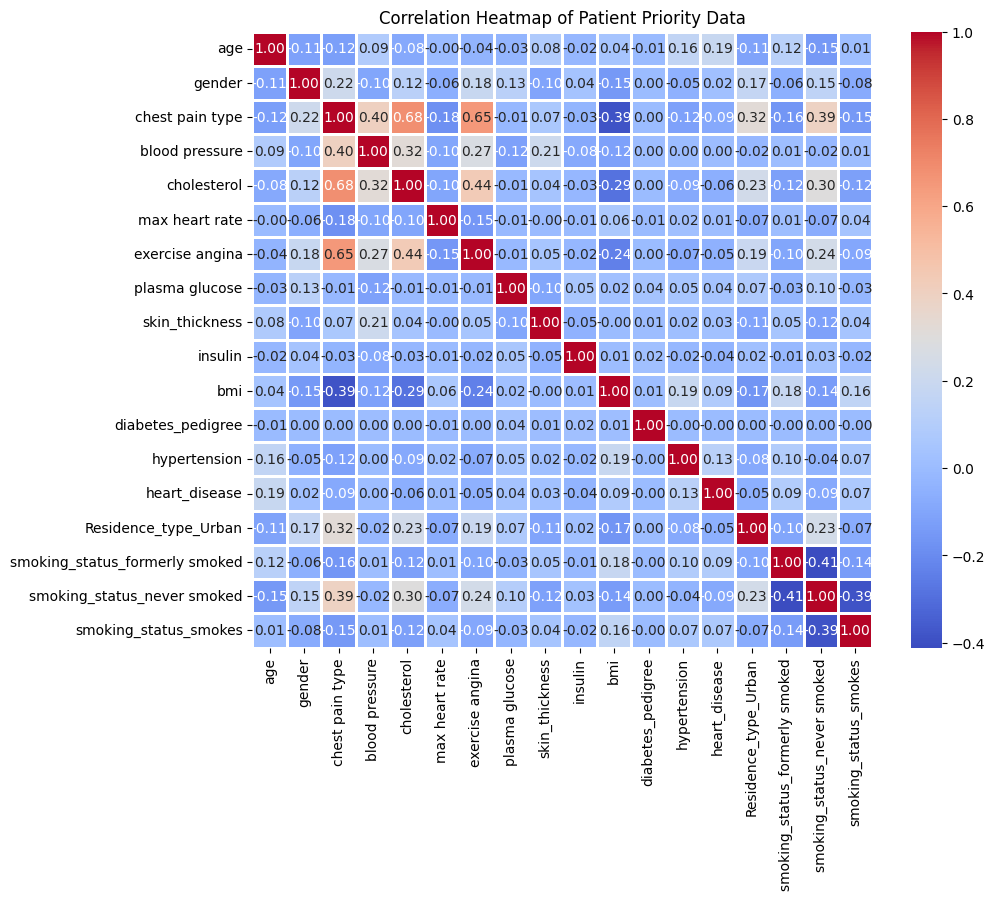

In [76]:
corr = patient_priority_enc.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=1
)
plt.title("Correlation Heatmap of Patient Priority Data")

#### Pairplots

In [77]:
# sns.pairplot(patient_priority_enc)

# Modeling
### A. Use sklearn.preprocessing.MinMaxScaler to scale the data and print the transformed header.

In [78]:
scaler = MinMaxScaler()
# Fit dataset into new variable using scaler
scaled_x = scaler.fit_transform(patient_priority_enc)
# create dataframe with index and column names
df_scaled = pd.DataFrame(scaled_x, columns=patient_priority_enc.columns, index=patient_priority_enc.index)
df_scaled.head()

,age,gender,chest pain type,blood pressure,cholesterol,max heart rate,exercise angina,plasma glucose,skin_thickness,insulin,bmi,diabetes_pedigree,hypertension,heart_disease,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0.222222,1.0,0.50,0.761905,1.000000,0.53125,0.0,0.367528,0.282051,0.122222,0.153982,0.166262,0.0,0.0,1.0,0.0,1.0,0.0
1,0.388889,0.0,0.75,0.952381,0.208333,0.28125,0.0,0.138171,0.333333,0.100000,0.136283,0.166262,0.0,0.0,1.0,0.0,1.0,0.0
2,0.166667,1.0,0.50,0.666667,1.000000,0.28125,0.0,0.298026,0.410256,0.233333,0.224779,0.166262,0.0,0.0,1.0,0.0,1.0,0.0
3,0.370370,0.0,1.00,0.742857,0.444444,0.28125,1.0,0.117320,0.384615,0.411111,0.136283,0.166262,0.0,0.0,1.0,0.0,1.0,0.0
4,0.481481,1.0,0.75,0.857143,0.312500,0.28125,0.0,0.367528,0.884615,0.022222,0.189381,0.166262,0.0,0.0,1.0,0.0,1.0,0.0


### B. Use sklearn.cluster.DBSCAN to cluster the data. Create at least 10 different models using various hyperparameter combinations (eps, min_samples, metric, p). Calculate the silhouette score for each model and tabulate the results. 

In [79]:
# ep = [0.5,0.7,1,1.2]

# # Loop the range while instantiating the model
# for e in ep:
#     db = DBSCAN(eps=e, min_samples=15, metric='euclidean')
#     labels = db.fit_predict(scaled_x)
#     sil_score = silhouette_score(scaled_x, labels, metric="euclidean")
#     print(f"When epsilon is {e} silhouette scor is: ", sil_score)

In [80]:
# ep = [0.97,0.98,0.99,1,1.01,1.02,1.03]

# # Loop the range while instantiating the model
# for e in ep:
#     db = DBSCAN(eps=e, min_samples=15, metric='euclidean')
#     labels = db.fit_predict(scaled_x)
#     sil_score = silhouette_score(scaled_x, labels, metric="euclidean")
#     print(f"When epsilon is {e} silhouette scor is: ", sil_score)

In [81]:
# samples = [5,10,15,20,25]

# # Loop the range while instantiating the model
# for sample in samples:
#     db = DBSCAN(eps=1, min_samples=sample, metric='euclidean')
#     labels = db.fit_predict(scaled_x)
#     sil_score = silhouette_score(scaled_x, labels, metric="euclidean")
#     print(f"When min samples is {sample} silhouette score is: ", sil_score)

In [82]:
# samples = [30,31,32,33]

# # Loop the range while instantiating the model
# for sample in samples:
#     db = DBSCAN(eps=1, min_samples=sample, metric='euclidean')
#     labels = db.fit_predict(scaled_x)
#     sil_score = silhouette_score(scaled_x, labels, metric="euclidean")
#     print(f"When min samples is {sample} silhouette score is: ", sil_score)

In [83]:
# samples = [26,27,28,29]

# # Loop the range while instantiating the model
# for sample in samples:
#     db = DBSCAN(eps=1, min_samples=sample, metric='euclidean')
#     labels = db.fit_predict(scaled_x)
#     sil_score = silhouette_score(scaled_x, labels, metric="euclidean")
#     print(f"When min samples is {sample} silhouette score is: ", sil_score)

In [84]:
tiny_eps       = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
small_eps      = [0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
small_samples  = [5, 10, 15, 20, 25]
high_samples   = [30, 35, 40, 45, 50]
giant_samples  = [60, 70, 80, 90, 100]

n_records = scaled_x.shape[0]
max_noise_ratio = 0.15

def run_grid(eps_list, samples_list, name):
    print(f"\n=== {name} ===")
    for eps in eps_list:
        for ms in samples_list:
            db = DBSCAN(eps=eps, min_samples=ms, metric='euclidean')
            labels = db.fit_predict(scaled_x)

            n_clusters = len(set(labels) - {-1})
            n_noise = np.sum(labels == -1)
            noise_ratio = n_noise / n_records

            # compute silhouette only if ≥2 clusters (ignoring noise)
            labels_no_noise = labels[labels != -1]
            X_no_noise = scaled_x[labels != -1]
            if len(np.unique(labels_no_noise)) >= 2:
                sil = silhouette_score(X_no_noise, labels_no_noise, metric="euclidean")
            else:
                sil = None

            # apply filters:
            if sil is not None and noise_ratio <= max_noise_ratio:
                print(
                    f"eps={eps}, min_samples={ms}, "
                    f"clusters={n_clusters}, noise={n_noise} "
                    f"({noise_ratio:.2%}), silhouette={sil:.4f}"
                )


run_grid(tiny_eps, small_samples, "tiny_eps / small_samples")
run_grid(tiny_eps, high_samples,  "tiny_eps / high_samples")
run_grid(tiny_eps, giant_samples,  "tiny_eps / giant_samples")
run_grid(small_eps, small_samples, "small_eps / small_samples")
run_grid(small_eps, high_samples,  "small_eps / high_samples")
run_grid(small_eps, giant_samples,  "small_eps / giant_samples")


=== tiny_eps / small_samples ===
eps=0.5, min_samples=5, clusters=41, noise=489 (7.02%), silhouette=0.3276
eps=0.5, min_samples=10, clusters=23, noise=746 (10.72%), silhouette=0.3361
eps=0.5, min_samples=15, clusters=19, noise=897 (12.89%), silhouette=0.3541
eps=0.5, min_samples=20, clusters=18, noise=994 (14.28%), silhouette=0.3616
eps=0.6, min_samples=5, clusters=44, noise=225 (3.23%), silhouette=0.3363
eps=0.6, min_samples=10, clusters=28, noise=455 (6.54%), silhouette=0.3387
eps=0.6, min_samples=15, clusters=24, noise=548 (7.87%), silhouette=0.3389
eps=0.6, min_samples=20, clusters=21, noise=642 (9.22%), silhouette=0.3383
eps=0.6, min_samples=25, clusters=19, noise=702 (10.08%), silhouette=0.3521

=== tiny_eps / high_samples ===
eps=0.6, min_samples=30, clusters=17, noise=797 (11.45%), silhouette=0.3533
eps=0.6, min_samples=35, clusters=17, noise=808 (11.61%), silhouette=0.3535
eps=0.6, min_samples=40, clusters=17, noise=811 (11.65%), silhouette=0.3536
eps=0.6, min_samples=45, clu

Looking at the results it seems like the best silhouette score and lowest noise percentage is somewhere around eps=0.7 and min_sample = 40

In [85]:
focus_eps = [0.66, 0.68, 0.70, 0.72, 0.74]
focus_samples = [36, 38, 40, 42, 44]

fine_tuning = run_grid(focus_eps, focus_samples, "focus_eps / focus_samples")


=== focus_eps / focus_samples ===
eps=0.66, min_samples=36, clusters=18, noise=716 (10.29%), silhouette=0.3521
eps=0.66, min_samples=38, clusters=18, noise=723 (10.39%), silhouette=0.3520
eps=0.66, min_samples=40, clusters=18, noise=726 (10.43%), silhouette=0.3521
eps=0.66, min_samples=42, clusters=17, noise=766 (11.00%), silhouette=0.3523
eps=0.66, min_samples=44, clusters=17, noise=767 (11.02%), silhouette=0.3523
eps=0.68, min_samples=36, clusters=18, noise=692 (9.94%), silhouette=0.3522
eps=0.68, min_samples=38, clusters=18, noise=702 (10.08%), silhouette=0.3522
eps=0.68, min_samples=40, clusters=18, noise=712 (10.23%), silhouette=0.3520
eps=0.68, min_samples=42, clusters=18, noise=718 (10.31%), silhouette=0.3519
eps=0.68, min_samples=44, clusters=17, noise=760 (10.92%), silhouette=0.3521
eps=0.7, min_samples=36, clusters=18, noise=690 (9.91%), silhouette=0.3522
eps=0.7, min_samples=38, clusters=18, noise=691 (9.93%), silhouette=0.3522
eps=0.7, min_samples=40, clusters=18, noise=69

In [86]:
chosen_db = DBSCAN(eps=0.74, min_samples=42, metric="euclidean")
label = chosen_db.fit_predict(scaled_x)
df_scaled["cluster"] = label
mask = label != -1
sil_score = silhouette_score(scaled_x[mask], label[mask], metric="euclidean")
sil_score

0.3521309374098924

<Axes: xlabel='cluster', ylabel='count'>

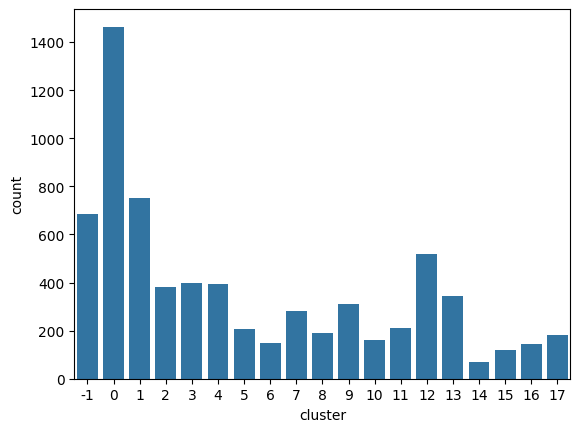

In [87]:
sns.countplot(df_scaled, x="cluster")

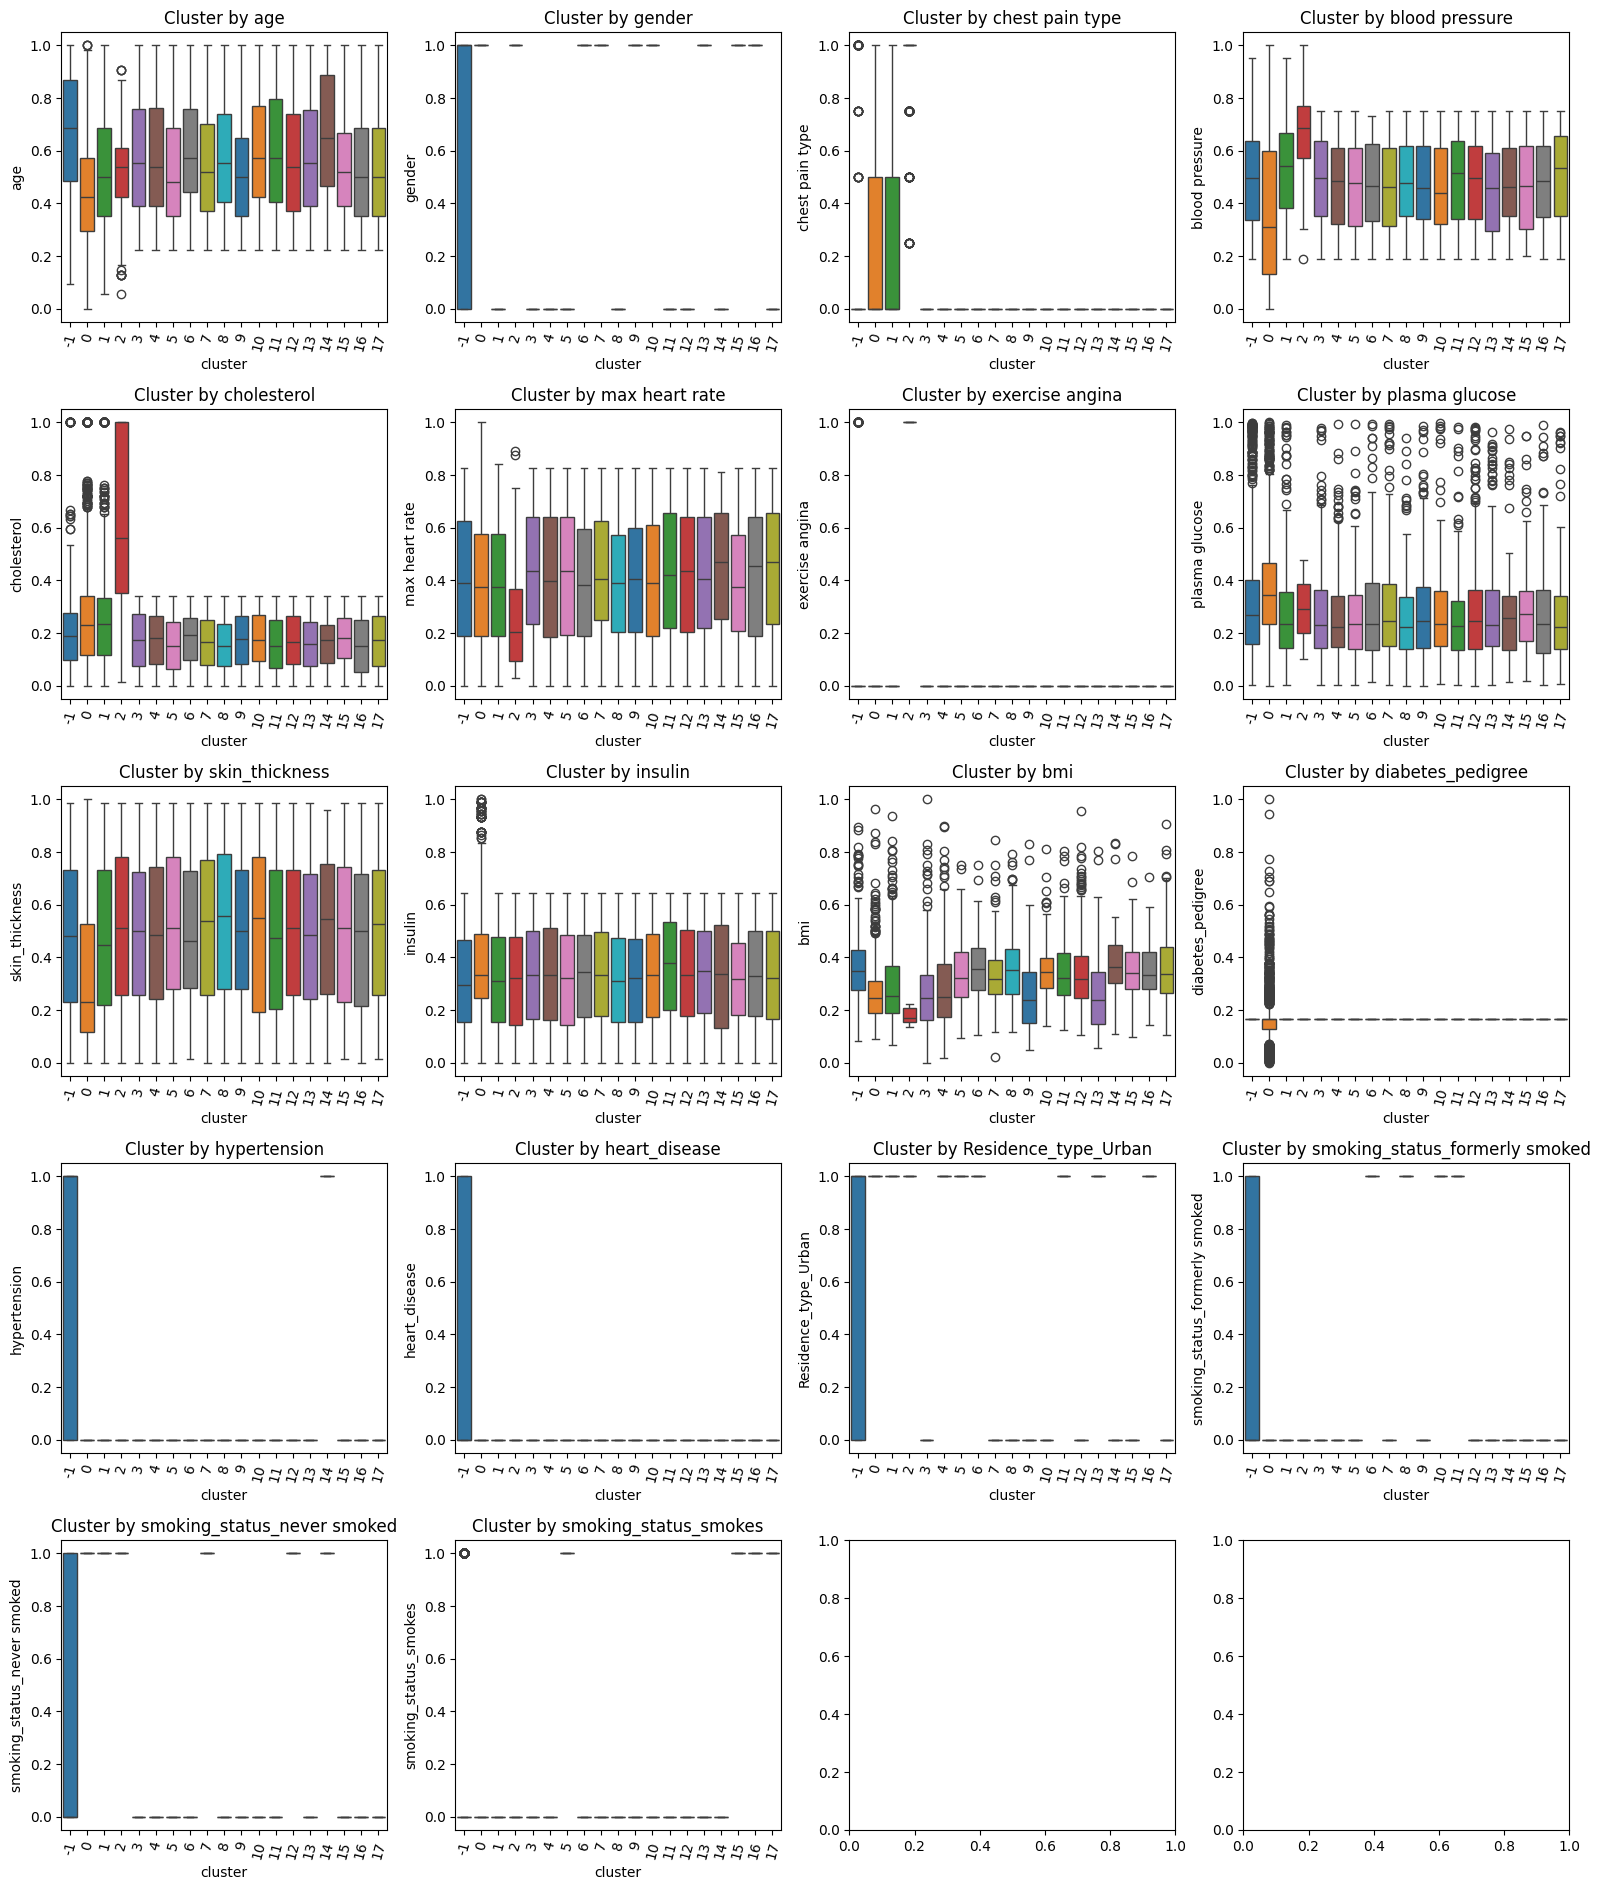

In [88]:
features = df_scaled.columns.tolist()
features.remove('cluster')
features
# For removing noise
df_scaled_no_noise = df_scaled[df_scaled['cluster']!=-1]

_, axes = plt.subplots(5, 4, figsize=(16, 19))
axes = axes.flatten()
for idx, feature in enumerate(features):
    sns.boxplot(data=df_scaled, x='cluster', y=feature, hue='cluster', palette='tab10', ax=axes[idx], legend=False)
    axes[idx].set_title(f"Cluster by {feature}")
    axes[idx].tick_params(axis='x', labelrotation=75)
plt.tight_layout()
plt.show()

<Axes: xlabel='chest pain type', ylabel='cholesterol'>

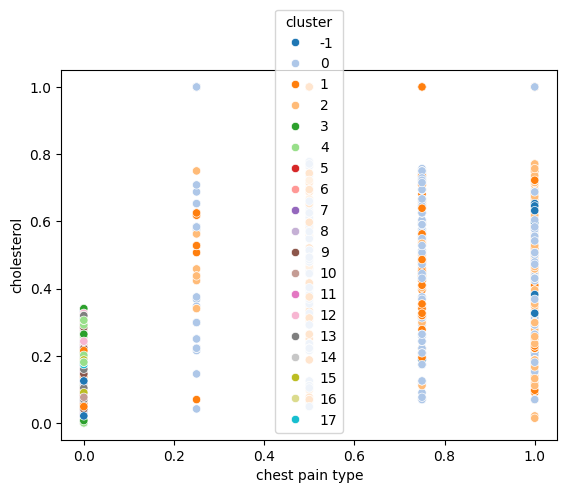

In [89]:
sns.scatterplot(df_scaled, x='chest pain type',y='cholesterol' ,hue='cluster', palette='tab20')

<Axes: xlabel='blood pressure', ylabel='cholesterol'>

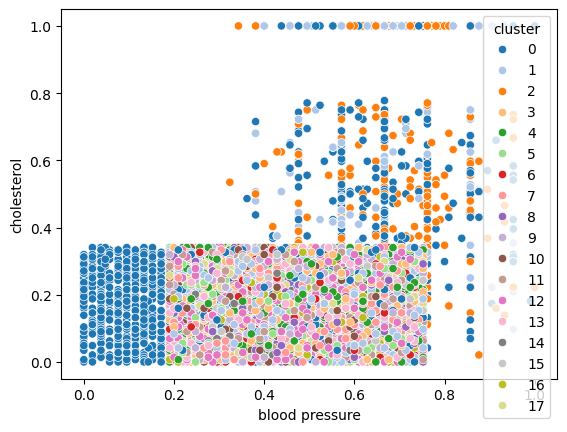

In [90]:
sns.scatterplot(df_scaled_no_noise, x='blood pressure',y='cholesterol' ,hue='cluster', palette='tab20')

In [91]:
summary = (
    df_scaled[df_scaled["cluster"] != -1]
    .groupby("cluster")
    .agg({
        "age": "median",
        "blood pressure": "median",
        "cholesterol": "median",
        "max heart rate": "median",
        "plasma glucose": "median",
        "bmi": "median",
        "hypertension": "mean",
        "Residence_type_Urban": "mean",
        "smoking_status_formerly smoked": "mean",
        "smoking_status_never smoked": "mean",
        "smoking_status_smokes": "mean",
    })
    .round(3)
)

summary

,age,blood pressure,cholesterol,max heart rate,plasma glucose,bmi,hypertension,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
cluster,,,,,,,,,,,
0,0.426,0.310,0.229,0.375,0.347,0.246,0.0,1.0,0.0,1.0,0.0
1,0.500,0.543,0.236,0.375,0.235,0.253,0.0,1.0,0.0,1.0,0.0
2,0.537,0.686,0.562,0.203,0.291,0.172,0.0,1.0,0.0,1.0,0.0
3,0.556,0.495,0.174,0.438,0.230,0.246,0.0,0.0,0.0,0.0,0.0
4,0.537,0.486,0.181,0.398,0.223,0.251,0.0,1.0,0.0,0.0,0.0
5,0.481,0.476,0.153,0.438,0.233,0.321,0.0,1.0,0.0,0.0,1.0
6,0.574,0.467,0.194,0.383,0.236,0.355,0.0,1.0,1.0,0.0,0.0
7,0.519,0.462,0.167,0.406,0.246,0.318,0.0,0.0,0.0,1.0,0.0
8,0.556,0.476,0.153,0.391,0.222,0.351,0.0,0.0,1.0,0.0,0.0


### C. Select the best model for this use case and justify your choice in Markdown. If initial models do not produce meaningful clusters, try additional hyperparameter settings and document any iterations and observations. 


# Conclusions
### A. 
Choose a pair of features and generate a scatter plot of the data, coloring points according to the clusters assigned by your best model. Comment on the plot in Markdown.



### B. 
Generate a histogram showing the number of customers in each cluster and provide observations in Markdown, noting whether cluster sizes make sense.



### C. 
Create a separate DataFrame for each cluster and use pandas.DataFrame.describe to describe each group.



### D.
Provide a written conclusion summarizing the characteristics of each patient group and rank the urgency level for each cluster. Include actionable recommendations for how the clusters could be used in a triage system.